<a href="https://colab.research.google.com/github/babsyco/Background_infraredLight_filtering/blob/main/double_source_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **An Approach To Filtering Background Light When Sampling Infrared Signals**

This notebook outlines a process for removing infrared (IR) background light when attempting to sample signal from an IR LED using a phototransistor. It begins with an overview of the basic hardware operation, followed by a description of an experiment designed to map physical characteristics of the system, then presents a method of data analysis and confirmation of improved results. It is hoped that this process can be generalised across a broad range of applications and hardware configurations.

<br>

## 1. A Simple Technique to Remove Background Light from an IR Signal

Let the desired signal be called `LEDsignal`, the infrared light from an IR LED, that is to be detected using a phototransistor. A simple technique to remove background IR light from samples of this signal is to rapidly pulse the IR LED, while taking two readings:

*   `backgroundLight`: a background light reading with IR LED turned off.
*   `LEDsignal_backgroundLight`: a reading with the IR LED turned on, that will also include the background light.

An attempt can then made to remove `backgroundLight` from `LEDsignal_backgroundLight` to acquire `LEDsignal`:



<body>
  <br>
  <center>
  <figure>
    <img src="https://drive.google.com/uc?export=download&id=1IU0MjmoAN_OMAiEKL9om8cD_UUTZu67G" width="900" align="middle">
    <figcaption>Fig 1. Process to acquire a sample of IR LED signal</figcaption>
  </figure>
  </center>
<br>
</body>


## 2. The problem

The simplest and most obvious method of obtaining values for `LEDsignal` is to subtract the `backgroundLight` samples from the `LEDsignal_backgroundLight` samples - however this has significant error for certain types of phototransistors. What is more, this error seems to vary depending on the levels of both `LEDsignal` and `backgroundLight`. That is:

<br>
<center>

`LEDsignal` = 𝒇(`LEDsignal_backgroundLight`, `backgroundLight`) ≠ `LEDsignal_backgroudLight` - `backgroundLight`

<br>
</center>

Where  𝒇  is unknown. From this point onwards, throughout this notebook:

<br>
<center>

`LEDsignal` = `LEDsignal_backgroudLight` - `backgroundLight` will be referred to as the **'simple calculation'**.

<br>
</center>


 This problem is evident in the test dataset:



In [1]:
###########
# IMPORTS #
###########
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from google.colab import files
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from IPython.display import Javascript
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from scipy.optimize import curve_fit
from scipy.stats import spearmanr
import operator

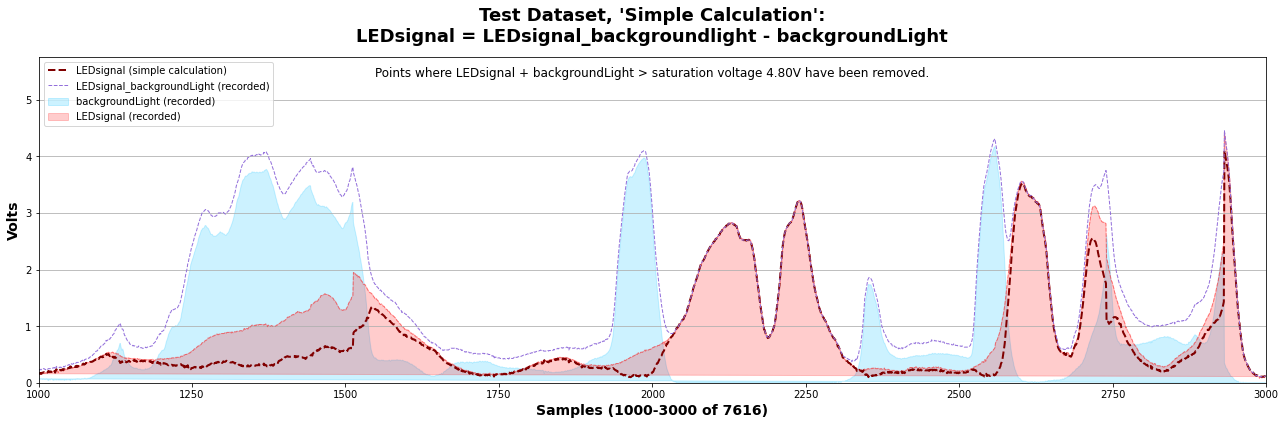

In [15]:
############################
# 1) IMPORT/PLOT TEST DATA #
############################

# DEFINE SATURATION VOLTAGE
saturation_voltage = 4.8 # volts

linePlot_start = 1000 #1000
linePlot_range = 2000 #2000

# IMPORT TEST DATA
double_IRsource_testData_URL = 'https://drive.google.com/uc?export=download&id=1SQh7owVrSR1yruJFID1FEd5a4CEu8rkA'
double_IRsource_testData_df = pd.read_csv(double_IRsource_testData_URL, error_bad_lines=False)

# CREATE NEW DATAFRAME
# Only including rows where IR_source_1 + IR_source_2 <= saturation voltage
double_IRsource_testData_df = double_IRsource_testData_df.query("IR_source_1 + IR_source_2 <= %s" % saturation_voltage).copy()
double_IRsource_testData_df['IR_source1_calc'] = double_IRsource_testData_df.apply(lambda row: row.IR_source_both - row.IR_source_2, axis = 1)

# FIGURE 2: LINE PLOTS
# data
line_1 = double_IRsource_testData_df['IR_source_1'][linePlot_start:linePlot_start+linePlot_range]
line_2 = double_IRsource_testData_df['IR_source_2'][linePlot_start:linePlot_start+linePlot_range]
line_3 = double_IRsource_testData_df['IR_source1_calc'][linePlot_start:linePlot_start+linePlot_range]
line_4 = double_IRsource_testData_df['IR_source_both'][linePlot_start:linePlot_start+linePlot_range]
line_x = [x + linePlot_start for x in range(linePlot_range)]
# plot
fig = plt.figure(figsize=(22,6))
ax1 = fig.add_subplot(111)
ax1.set_xlim(linePlot_start, linePlot_start + linePlot_range)
ax1.set_ylim(0, 1.2*saturation_voltage)
ax1.set_title("Test Dataset, 'Simple Calculation':\nLEDsignal = LEDsignal_backgroundlight - backgroundLight", fontsize=18, fontweight='bold', pad=15)
ax1.set_ylabel('Volts', fontsize=14, fontweight='bold')
ax1.set_xlabel('Samples (%d-%d of %d)' % (linePlot_start, linePlot_start+linePlot_range, double_IRsource_testData_df.shape[0]), fontsize=14, fontweight='bold')
ax1.plot(line_x, line_1, color='red', linewidth=1, linestyle='--', alpha=0.4)
ax1.fill(line_x, line_2, alpha=0.2, label='backgroundLight (recorded)', color='deepskyblue', zorder=-1)
ax1.plot(line_x, line_3, label='LEDsignal (simple calculation)', color='maroon', linewidth=2, linestyle='--')
ax1.fill(line_x, line_1, alpha=0.2, label='LEDsignal (recorded)', color='red', zorder=-1)
ax1.plot(line_x, line_4, label='LEDsignal_backgroundLight (recorded)', color='mediumpurple', linewidth=1, linestyle='--')
ax1.text(sum(ax1.get_xlim())/2, ax1.get_ylim()[1]*0.97, 'Points where LEDsignal + backgroundLight > saturation voltage %.2fV have been removed.' \
         % saturation_voltage, va='top',fontsize=12, ha='center')
ax1.legend(loc='upper left')
plt.grid(axis = 'y')
plt.show()

It can be seen above: for many values of `LEDsignal` and `backgroundLight`, the **simple calculation** does not align with the true value of `LEDsignal`, and the error can exceed 20% of the entire **Vout** range. 

## 3. Experimental Setup

The following experiment and data analysis is designed to develop an algorithm that adequately approximates 𝒇 as described in **section 2**. In this experiment two IR LEDs were used to simulate `LEDsignal` and `backgroundLight` as described in **Section 1**:

* `IR_source_1`: a simulation of `LEDsignal` (in real-world applications this cannot be directly measured when detecting a signal if background light is present).
* `IR_source_2`: a simulation of `backgroundLight` (this is directly measured in real-world applications).
* `IR_source_both`: measured value when both `IR_source_1` and `IR_source_2` are present, equivalent to `LEDsignal_backgroundLight` as described in **Section 1** (this is directly measured in real-world applications).

The following sampling loop was run, while `IR_source_1` and `IR_source_2` were moved around in physical space independently, relative to the detecting phototransistor, as a way of varying their intensities:



1.   Turn `IR_source_1` on, take sample, turn off.
2.   Turn `IR_source_2` on, take sample, turn off.
3.   Turn both on, record the sample `IR_source_both`, turn both off.
4.   Repeat.

Total loop time: ~2.5ms:

<body>
  <br>
  <center>
  <figure>
    <img src="https://drive.google.com/uc?export=download&id=1RsivbmyQypdyHJ0rvH3svxEmIL6uqHP8" width="800" align="middle">
    <figcaption>Fig 2. Left: one set of samples. Right: physical setup.</figcaption>
  </figure>
  </center>
<br>
</body>


The data gathered during this experiment allows comparisons to be made between the true values of `IR_source_1` samples, and methods of calculating those values given the `IR_source_2` and `IR_source_both` samples, such as the **simple calculation**. And most importantly it allows this comparison to be done across independently changing `IR_source_1` and `IR_source_2` signal levels.

<br>

## 4. Visualising/Analysing the data
### 4.1 Visualising the raw data

The first steps are to inspect the data as follows:

1. Examine the dataset directly.
2. Examine the data in timeseries format.
3. Examine how the 3 different sample streams relate to each other.







In [3]:
###########################################
# 4.1.1 IMPORT/INSPECT DOUBLE SOURCE DATA #
###########################################

double_IRsource_data_URL = 'https://drive.google.com/uc?export=download&id=1SQh7owVrSR1yruJFID1FEd5a4CEu8rkA'

double_IRsource_df = pd.read_csv(double_IRsource_data_URL, error_bad_lines=False)
print("\nRANDOM SAMPLE OF DATASET:")
display(double_IRsource_df.sample(n=10))
print('\nDATASET DIMENSIONS:\n')
print('%d rows, %d columns' % (double_IRsource_df.shape[0], double_IRsource_df.shape[1]))


RANDOM SAMPLE OF DATASET:


IR_source_1  IR_source_2  IR_source_both
8238         2.84         0.20            2.92
6629         3.90         2.12            4.60
8118         1.30         0.76            1.74
6182         1.18         0.22            1.29
1572         2.05         3.34            4.15
688          0.23         0.08            0.31
3176         4.88         1.31            4.95
4368         0.06         0.10            0.18
3254         0.08         0.00            0.11
2235         2.46         0.00            2.42


DATASET DIMENSIONS:

8575 rows, 3 columns


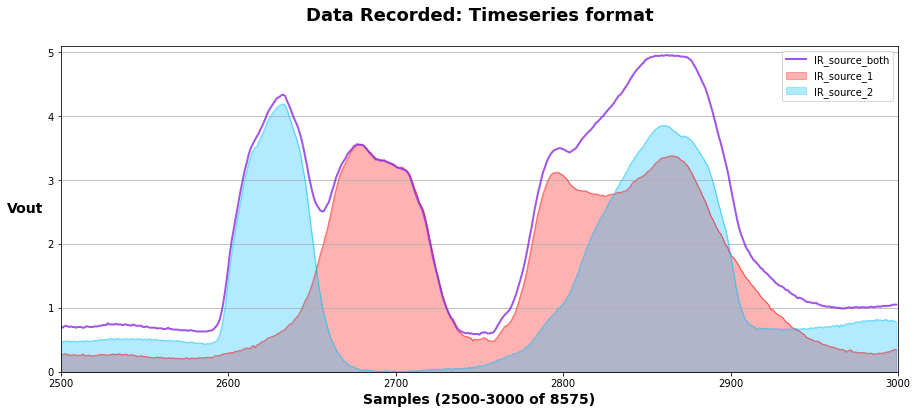

In [4]:
#############################################
# 4.1.2 PLOT DOUBLE SOURCE DATA: TIMESERIES #
#############################################
start_sample = 2500
n_samples = 500

x_vals = [x + start_sample for x in range(n_samples)]
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111)
ax.set_title("Data Recorded: Timeseries format", fontsize=18, pad=25, fontweight='bold')
ax.plot(double_IRsource_df['IR_source_1'][start_sample:start_sample + n_samples],color='red', alpha=0.5, linewidth=1, linestyle='-')
ax.fill_between(x_vals, double_IRsource_df['IR_source_1'][start_sample:start_sample + n_samples], color='red', alpha=0.3, zorder=-1, label='IR_source_1')
ax.plot(double_IRsource_df['IR_source_2'][start_sample:start_sample + n_samples],color='deepskyblue', alpha=0.5, linewidth=1, linestyle='-',)
ax.fill_between(x_vals, double_IRsource_df['IR_source_2'][start_sample:start_sample + n_samples], color='deepskyblue', alpha=0.3, zorder=-1, label='IR_source_2')
ax.plot(double_IRsource_df['IR_source_both'][start_sample:start_sample + n_samples],color='blueviolet', alpha=0.8, linewidth=2, label='IR_source_both')
ax.legend()
ax.set_xlabel('Samples (%d-%d of %d)' % (start_sample, start_sample+n_samples, len(double_IRsource_df['IR_source_2'])),
                                         fontsize=14, fontweight='bold')
ax.set_ylabel("Vout", rotation='horizontal', ha='right', va='center', fontsize=14, fontweight='bold')
ax.set_xlim(start_sample, start_sample+n_samples)
ax.set_ylim(0, 5.1)
plt.grid(axis = 'y')
plt.show()

In [5]:
######################
# DATA VIS FUNCTIONS #
######################

# Produces a 4x4 grid of a surface rotated, followed by one zoomed plot
# of the surface rotated zoom_rotation degrees (on the xy plane).
# zoom_plot = True/False.
# Requires plt.show() to be called after function, to show zoom plot. This 
# is so that zoom plot can be further added to if desired.
def plotRotatingSurface(x_vals, y_vals, z_vals, title, subtitle, ax_labels, colormap, zoom_plot, zoom_rotation):
  
  # create figure
  fig = plt.figure(figsize=(20,20))
  plt.suptitle(title, fontsize=20, fontweight="bold", y=1.01)
  plt.title(subtitle, fontsize=15, fontweight="bold", y=1.01)
  plt.axis("off")

  # create and fill the 16 subplots
  i = 0
  while(i < 16):
    surface_h_rotation = i*22
    ax = fig.add_subplot(4,4,i+1, projection='3d')
    ax.set_xlabel("x: " + ax_labels[0])
    ax.set_ylabel("y: " + ax_labels[1])
    ax.set_zlabel("z: " + ax_labels[2])
    ax.set_title("%d° rotation" % (surface_h_rotation))
    ax.plot_trisurf(x_vals, y_vals, z_vals, cmap=colormap, edgecolor='none', antialiased=False)
    ax.view_init(20, surface_h_rotation)
    i += 1
  fig.tight_layout(pad=6)
  plt.show()

  # create zoomed single surface
  if zoom_plot:
    fig = plt.figure(figsize=(8,8))
    plt.suptitle(title + " (zoomed)", fontsize=20, fontweight="bold", y=1)
    plt.title(subtitle, fontsize=13)
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel("x: " + ax_labels[0], fontsize=13)
    ax.set_ylabel("y: " + ax_labels[1], fontsize=13)
    ax.set_zlabel("z: " + ax_labels[2], fontsize=13)
    ax.set_title("(%d° rotation)" % (zoom_rotation), fontsize=15)
    ax.plot_trisurf(x_vals, y_vals, z_vals, cmap=colormap, edgecolor='none', antialiased=False)
    ax.view_init(20, zoom_rotation)
    fig.tight_layout(pad=1)
  return ax

def plotSingleSurface(ax, x, y, z, colormap, title, ax_labels, rotation):
  ax.plot_trisurf(x,y,z, cmap=colormap)
  ax.view_init(20, rotation)
  ax.set_title(title, fontweight='bold', fontsize=12)
  ax.set_xlabel(ax_labels[0])
  ax.set_ylabel(ax_labels[1])
  ax.set_zlabel(ax_labels[2])


<IPython.core.display.Javascript object>

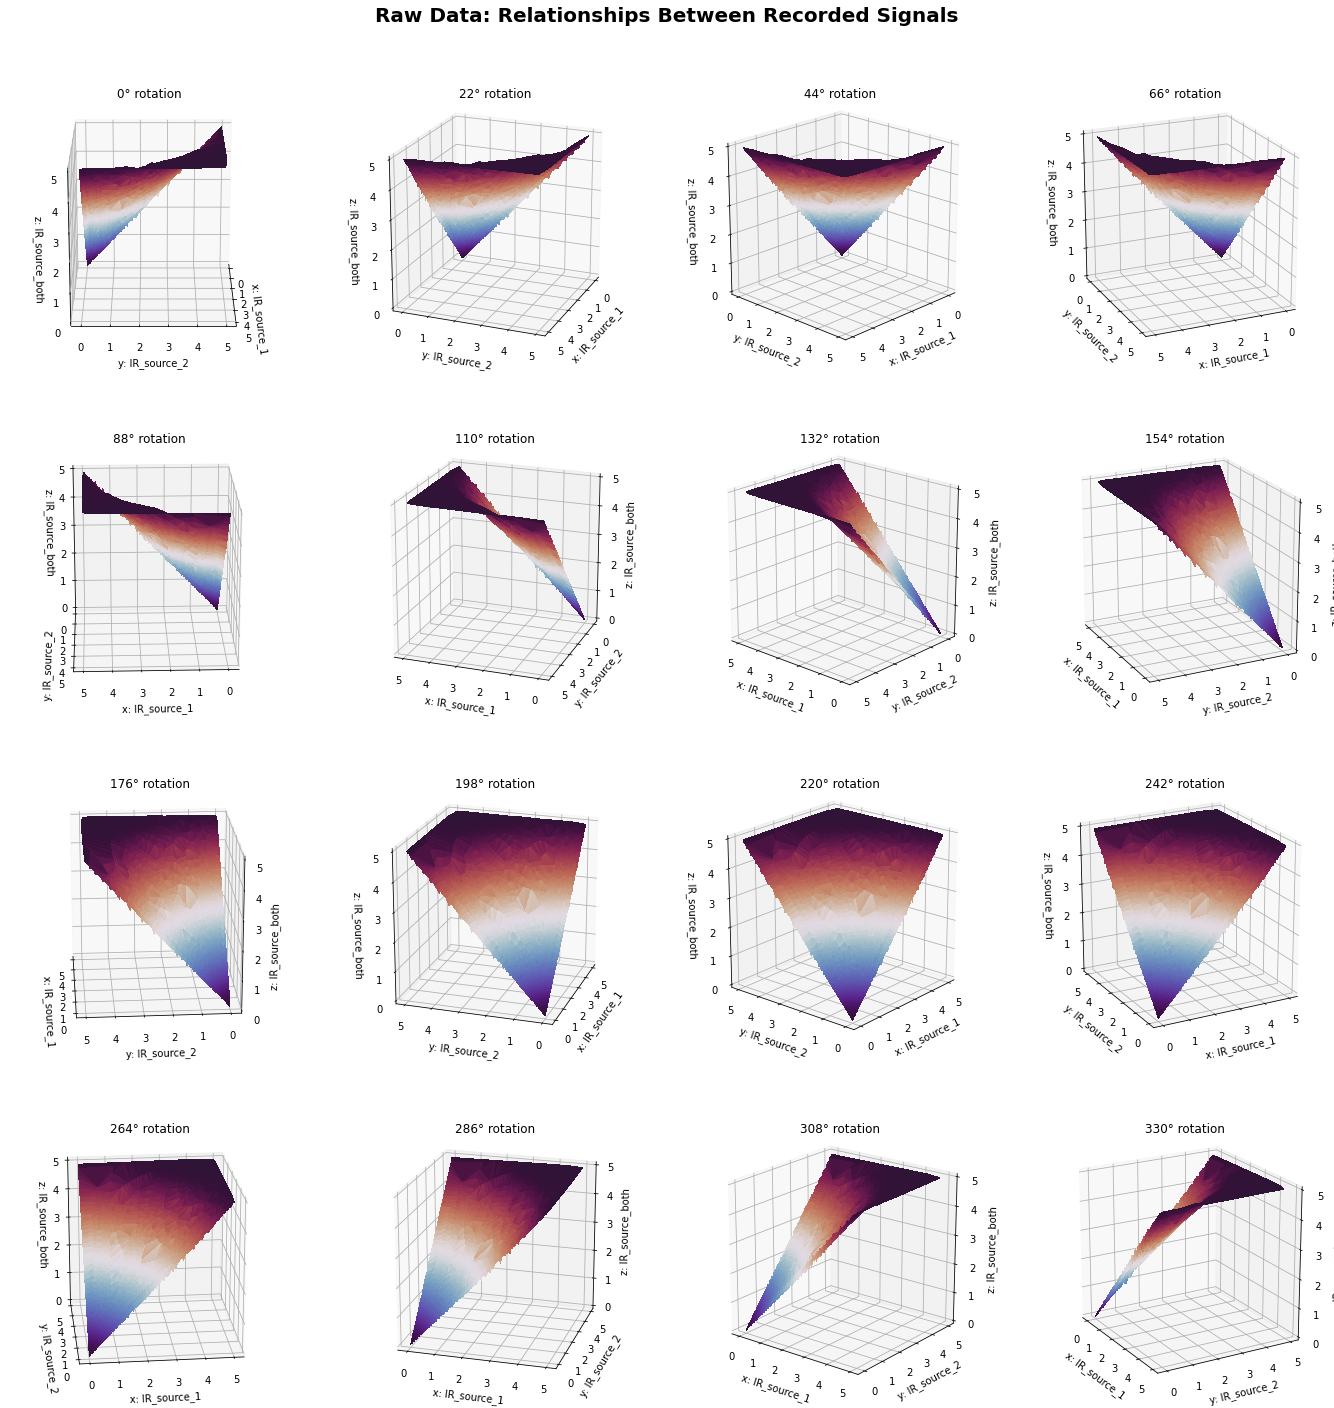

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


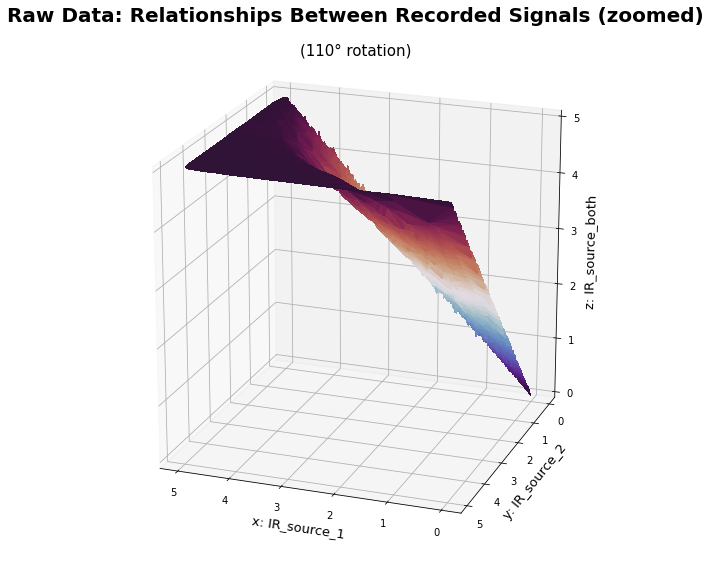

In [6]:
#############################################
# 4.1.3 VISUALISE RELATIONSHIPS IN RAW DATA #
#############################################

# format size of cell output
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

# Create values for plotting functions
x_vals = double_IRsource_df['IR_source_1']
y_vals = double_IRsource_df['IR_source_2']
z_vals = double_IRsource_df['IR_source_both']
zoom_rotation = 110
title = "Raw Data: Relationships Between Recorded Signals"
subtitle = ""
ax_labels = ['IR_source_1', 'IR_source_2', 'IR_source_both']
colormap = cm.twilight_shifted
zoom_plot = True
# plot
plotRotatingSurface(x_vals, y_vals, z_vals, title, subtitle, ax_labels, colormap, zoom_plot, zoom_rotation)
plt.show()

With a bit of consideration, the issue this experiment is trying to address can already be seen above. More on this in **section 4.3**. 

**Also note that any time this colour scheme is used it indicates that raw data is being visualised**.

<br>

### 4.2 Data Pre-processing

It can be seen above that there are no major anomalies in the data that need addressing, however not all datapoints are relevant to this analysis. Any set of samples where `IR_source_1` + `IR_source_2` > **satuation voltage 4.8V**, are outside the scope of this problem - they must be addressed through hardware, in an attempt to prevent the sensor saturating. When they are removed, the data looks as follows:

In [7]:
##################################
# CREATE PRE-PROCESSED DATAFRAME #
##################################

# The dataframe created below will contain several new columns with useful
# calculated values (as well as the three original columns):
#
# # IR_source1_calc:                  IR_source_both - IR_source_2
# # IR_both_calc                      IR_source_1 + IR_source_2
# # IR_source_both_calcMinMeas:       IR_both_calc - IR_source_both (calculated minus measured)
# # IR_source_both_measMinCalc        IR_source_both - IR_both_calc (measured minus calculated)

# CREATE NEW DATAFRAME
# Only including rows where IR_source_1 + IR_source_2 <= saturation voltage
double_IRsource_preProc_df = double_IRsource_df.query("IR_source_1 + IR_source_2 <= %s" % saturation_voltage).copy()

# ADD NEW COLUMNS
double_IRsource_preProc_df['IR_source1_calc'] = double_IRsource_preProc_df.apply(lambda row: row.IR_source_both - row.IR_source_2, axis = 1)
double_IRsource_preProc_df['IR_both_calc'] = double_IRsource_preProc_df.apply(lambda row: row.IR_source_1 + row.IR_source_2, axis = 1)
double_IRsource_preProc_df['IR_source_both_calcMinMeas'] = double_IRsource_preProc_df.apply(lambda row: row.IR_both_calc - row.IR_source_both, axis = 1)
double_IRsource_preProc_df['IR_source_both_measMinCalc'] = double_IRsource_preProc_df.apply(lambda row: row.IR_source_both - row.IR_both_calc, axis = 1)

# DISPLAY SUMMARY
if False:
  print("\nPRE-PROCESSED DATAFRAME SUMMARY:")
  print("\nColumns (%d):" % double_IRsource_preProc_df.shape[1])
  for column in double_IRsource_preProc_df.columns:
    print(" " + column)
  print("\n'IR_both_calc' max value (should be <= saturation voltage %.2fV):" % saturation_voltage)
  print(" %.2fV" % double_IRsource_preProc_df["IR_both_calc"].max())

  print("\nROWS:")
  print(" %d" % double_IRsource_preProc_df.shape[0])

<IPython.core.display.Javascript object>

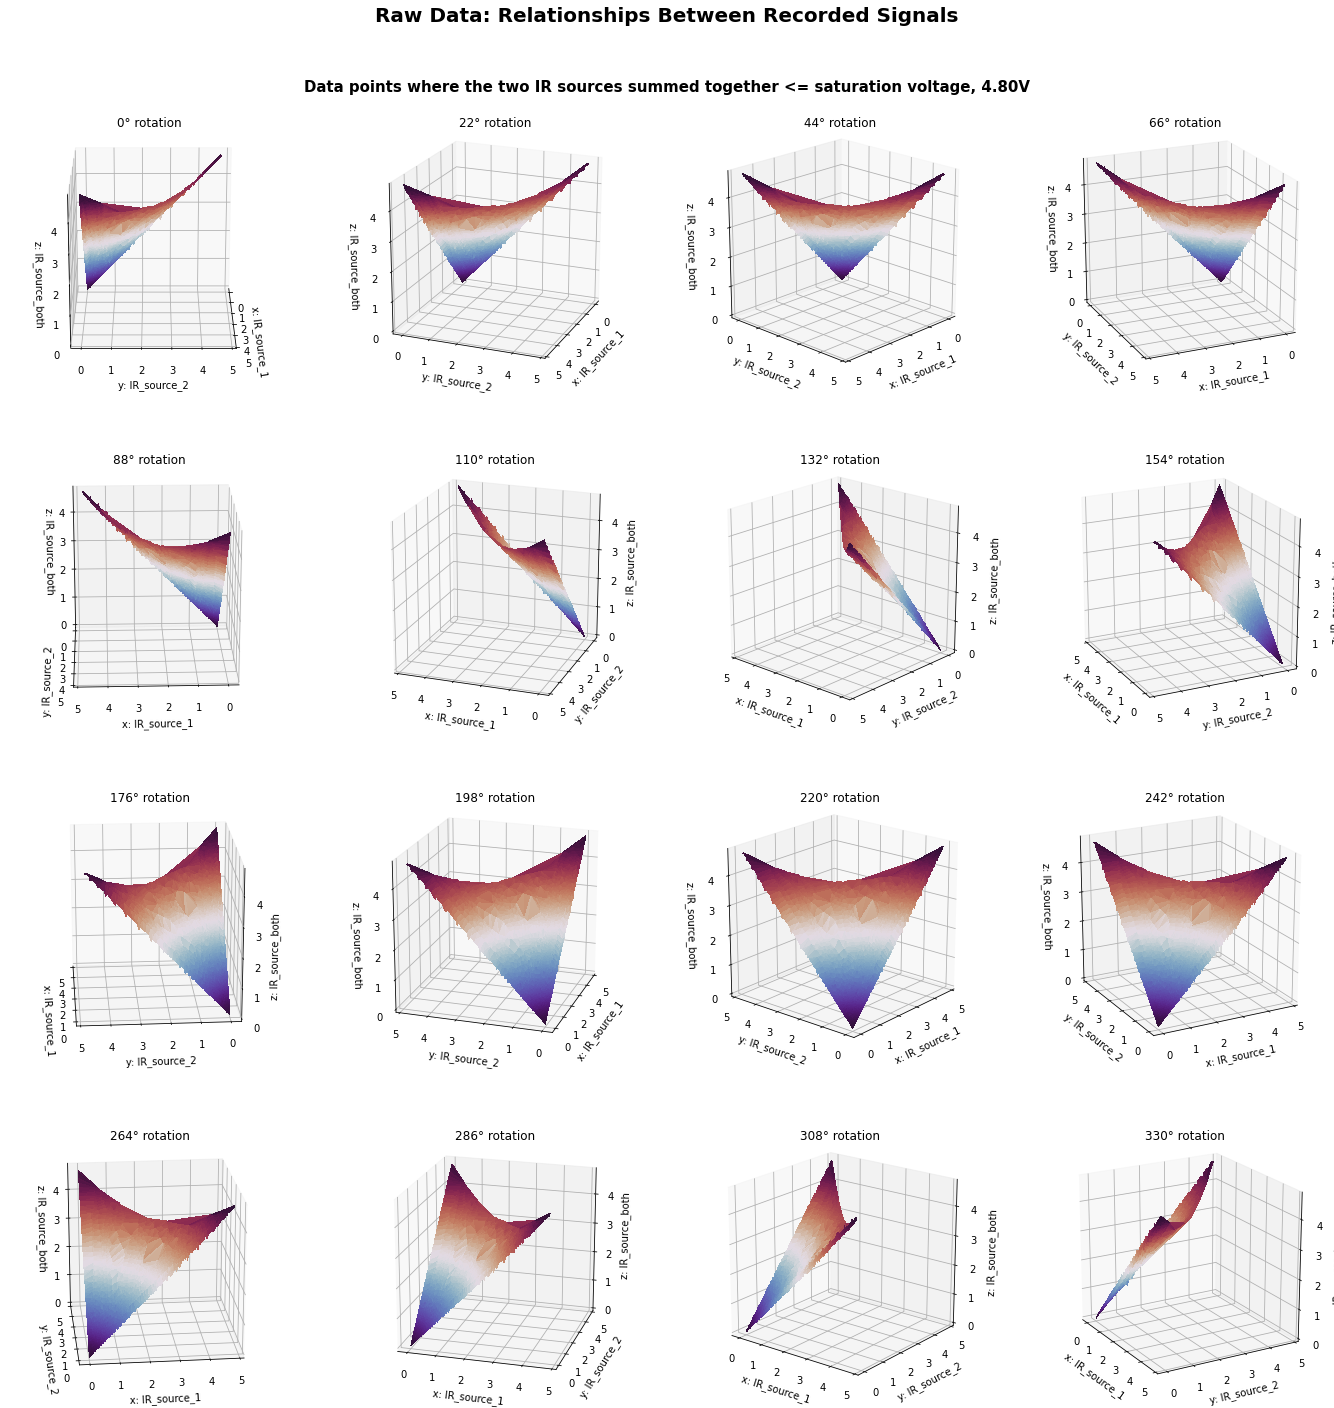

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


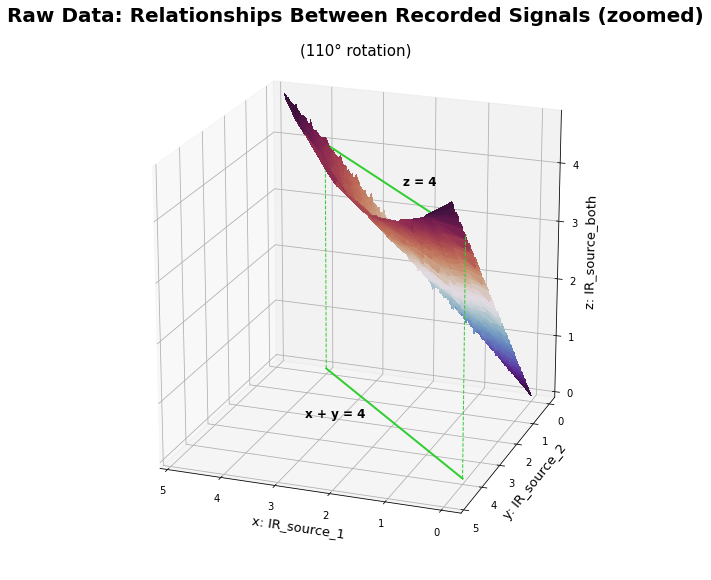

In [8]:
##############################################
# VISUALISE PRE-PROCESSED DATA RELATIONSHIPS #
##############################################

# format size of cell output
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

x_vals = double_IRsource_preProc_df['IR_source_1']
y_vals = double_IRsource_preProc_df['IR_source_2']
z_vals = double_IRsource_preProc_df['IR_source_both']
zoom_rotation = 110
title = "Raw Data: Relationships Between Recorded Signals"
subtitle = "Data points where the two IR sources summed together <= saturation voltage, %0.2fV" % saturation_voltage
ax_labels = ['IR_source_1', 'IR_source_2', 'IR_source_both']
colormap = cm.twilight_shifted
zoom_plot = True

# create plots
ax = plotRotatingSurface(x_vals, y_vals, z_vals, title, subtitle, ax_labels, colormap, zoom_plot, zoom_rotation)
# add z = x + y lines to zoom plot
ax.plot([0,4],[4,0],[0,0], color='limegreen', linewidth=2, zorder=4)
ax.plot([0,4],[4,0],[4,4], color='limegreen', linewidth=2)
ax.plot([4,4],[0,0],[0,4], color='limegreen', linestyle='--', linewidth=1)
ax.plot([0,0],[4,4],[0,4], color='limegreen', linestyle='--', zorder=4,  linewidth=1)
ax.text(2.5,2,0, 'x + y = 4', fontsize=12, ha='right', fontweight='bold')
ax.text(1.8,2,4, 'z = 4', fontsize=12, ha='left', va='bottom', fontweight='bold')
plt.show()

### 4.3 Observing the problem in the data

As stated in **section 4.1** the problem is immediately apparent. The first thing to note is diagonal lines across the **xy** plane represent **Ax + By = C** (where **A**,**B** and **C** are constants). Most relevant to this analysis are lines where **A = B = 1**. Eg:

<center>

The line running from **[4,0,0]** to **[0,4,0]** represents **x + y = 4** (green lines above).
</center>

So while the ascending triangular shape of the surface is as expected - `IR_source_both` increases as `IR_source_1` or `IR_source2` do - its concave mid-section is anomalous. If the surface was compliant with the simple equation:

<center>

 **z = x + y**<br>or in other words:<br> 
 `IR_source_both` = `IR_source_1` + `IR_source_2`
 </center>

<br>

**z** values should be constant along these diagonal lines. The surface should have no concavity and should follow the upper green line. This is confirmed below:

<IPython.core.display.Javascript object>

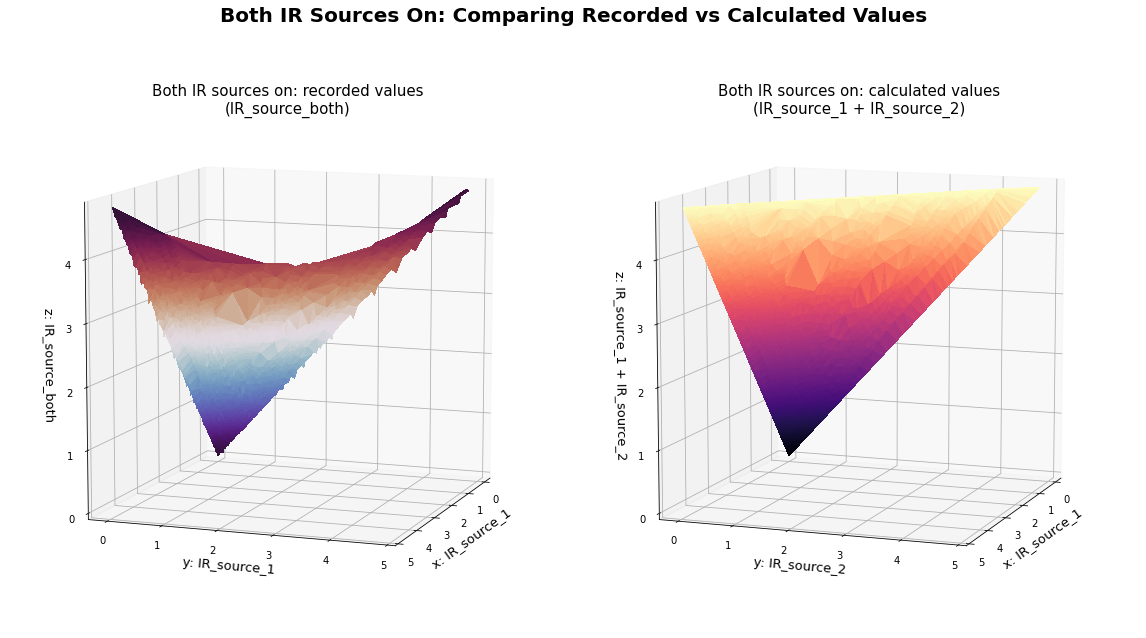

In [9]:
# format size of cell output
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

fig_title = "Both IR Sources On: Comparing Recorded vs Calculated Values"
x_vals = double_IRsource_preProc_df['IR_source_1']
y_vals = double_IRsource_preProc_df['IR_source_2']
z_vals1 = double_IRsource_preProc_df['IR_source_both']
z_vals2 = double_IRsource_preProc_df['IR_both_calc']
x_label = 'IR_source_1'
y_label = 'IR_source_2'
z1_label = "IR_source_both"
z2_label = "IR_source_1 + IR_source_2"
rawData_colormap = cm.twilight_shifted
preProcData_colormap = cm.magma
dualPlot_rotation = 20


fig = plt.figure(figsize=(16,8))
plt.axis("off")
# Left side: recorded values
plt.suptitle(fig_title, fontsize=20, fontweight="bold", y=1.1)
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_xlabel("x: " + x_label, fontsize=13)
ax1.set_ylabel("y: " + x_label, fontsize=13)
ax1.set_zlabel("z: " + z1_label, fontsize=13)
ax1.set_title("Both IR sources on: recorded values\n(IR_source_both)", fontsize=15)
ax1.plot_trisurf(x_vals, y_vals, z_vals1, cmap=rawData_colormap, edgecolor='none', antialiased=False)
ax1.view_init(10, dualPlot_rotation)
# right side: calculated values_
ax2 = fig.add_subplot(122, projection='3d')
ax2.set_xlabel("x: " + x_label, fontsize=13)
ax2.set_ylabel("y: " + y_label, fontsize=13)
ax2.set_zlabel("z: " + z2_label, fontsize=13)
ax2.set_title("Both IR sources on: calculated values\n(IR_source_1 + IR_source_2)", fontsize=15)
ax2.plot_trisurf(x_vals, y_vals, z_vals2, cmap=preProcData_colormap, edgecolor='none', antialiased=False)
ax2.view_init(10, dualPlot_rotation)
fig.tight_layout(pad=1)
plt.show()

<br>

**Also note that whenever the colour scheme on the right is used, it indicates that processed data is being plotted.**

<br>

Going one step further, plotting the difference between:
* 'Expected' values when both IR sources are on: `IR_source_1` + `IR_source_2`, and
* Recorded values when both IR sources are on: `IR_source_both`

Reveals the distribution and magnitude of the discrepancy for various values of `IR_source_1` and `IR_source_2`:

<IPython.core.display.Javascript object>

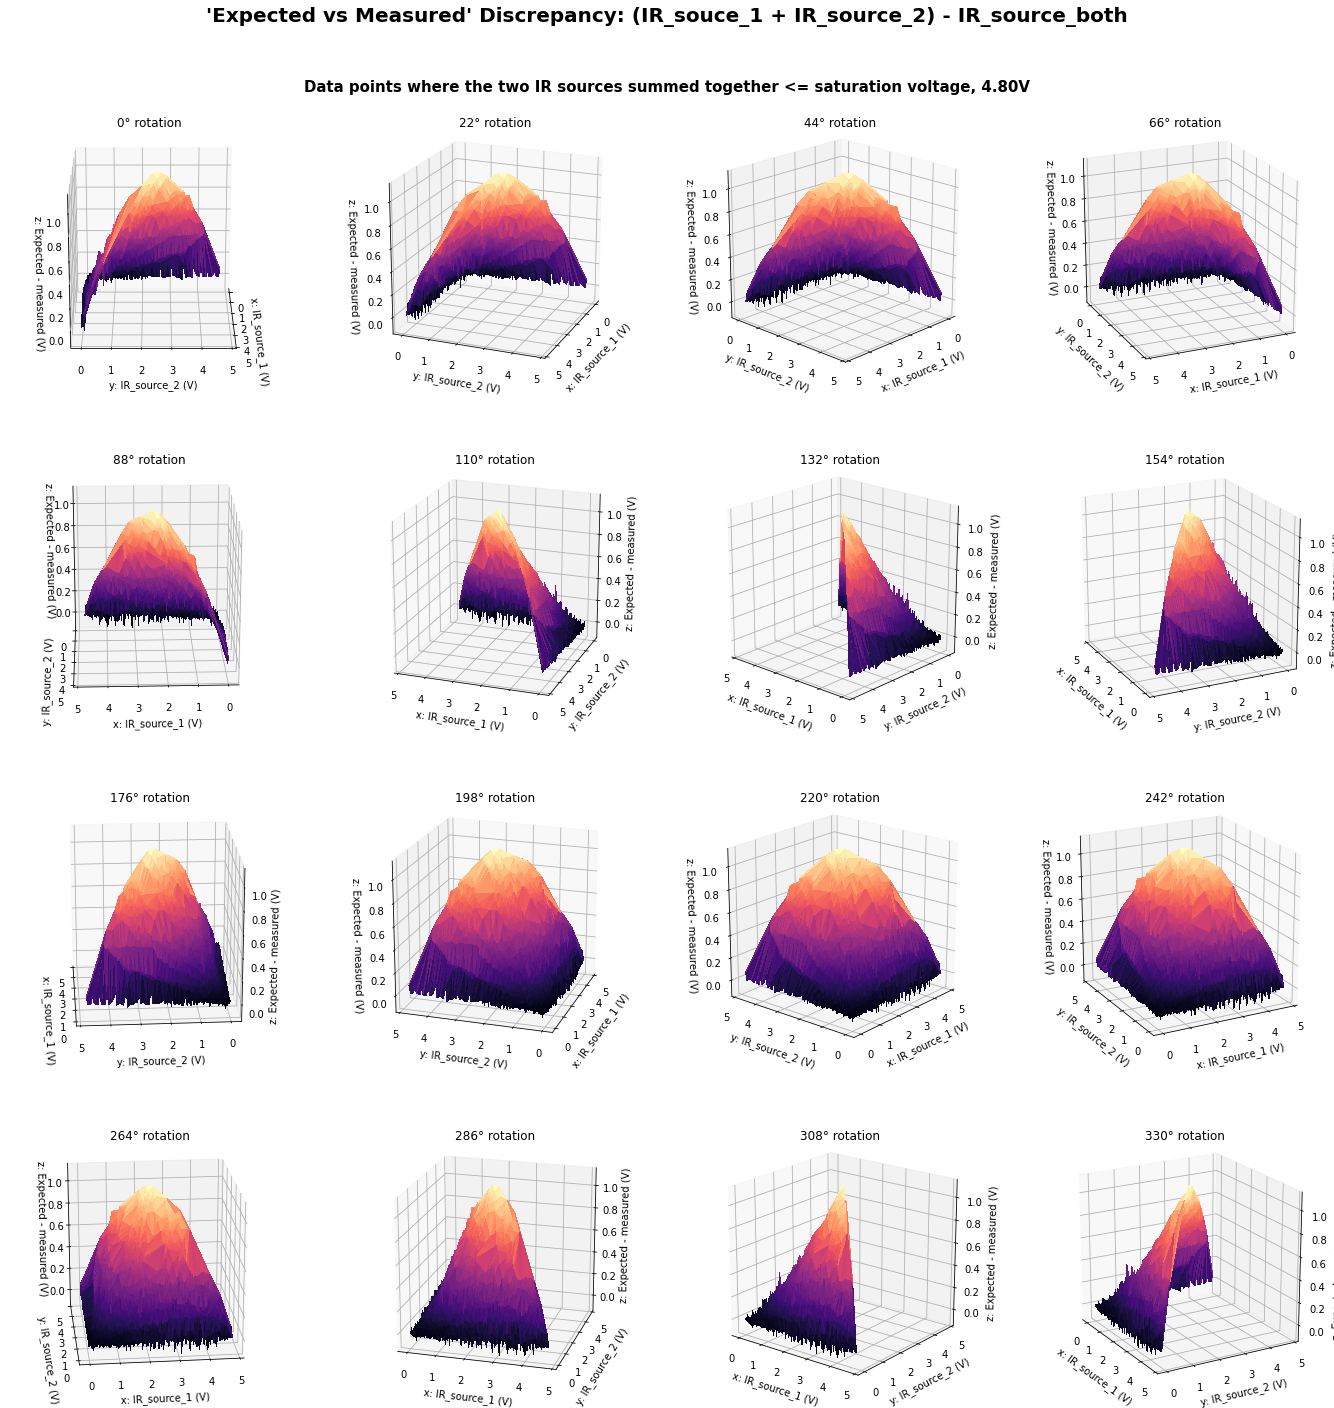

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


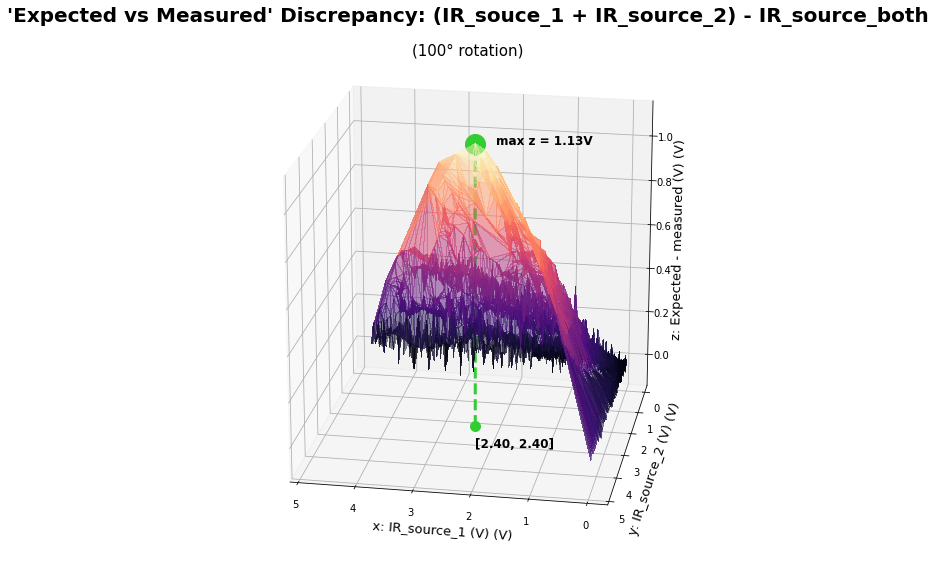

In [10]:
########################
# PLOT DIFFERENCE:     #
# EPXECTED VS MEASURED #
########################

# format size of cell output
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

# creats plot variables
x_vals = double_IRsource_preProc_df['IR_source_1']
y_vals = double_IRsource_preProc_df['IR_source_2']
z_vals = double_IRsource_preProc_df['IR_source_both_calcMinMeas']
zoom_rotation = np.nan
title = "'Expected vs Measured' Discrepancy: (IR_souce_1 + IR_source_2) - IR_source_both"
subtitle = "Data points where the two IR sources summed together <= saturation voltage, %0.2fV" % saturation_voltage
ax_labels = ['IR_source_1 (V)', 'IR_source_2 (V)', 'Expected - measured (V)']
colormap = cm.magma
zoom_plot = False

# plot
plotRotatingSurface(x_vals, y_vals, z_vals, title, subtitle, ax_labels, colormap, zoom_plot, zoom_rotation)

# Zoomed plot with peak z value
zoom_rotation = 100
fig = plt.figure(figsize=(8,8))
plt.suptitle(title, fontsize=20, fontweight="bold", y=1)
plt.title(subtitle, fontsize=13)
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("x: " + ax_labels[0]  + " (V)", fontsize=13)
ax.set_ylabel("y: " + ax_labels[1]  + " (V)", fontsize=13)
ax.set_zlabel("z: " + ax_labels[2] + " (V)", fontsize=13)
ax.set_title("(%d° rotation)" % (zoom_rotation), fontsize=15)
ax.plot_trisurf(x_vals, y_vals, z_vals, cmap=colormap, edgecolor='none', alpha=0.5, zorder=-1, antialiased=False)
ax.view_init(20, zoom_rotation)
fig.tight_layout(pad=1)
# add max-z point
max_idx = double_IRsource_preProc_df['IR_source_both_calcMinMeas'].idxmax()
max_row = double_IRsource_preProc_df.loc[max_idx]
ax.plot([max_row['IR_source_1']], [max_row['IR_source_2']], [max_row['IR_source_both_calcMinMeas']], marker='o', markersize=20, color='limegreen')
ax.plot([max_row['IR_source_1']]*2, [max_row['IR_source_2']]*2, [ax.get_zlim()[0], ax.get_zlim()[1]], marker='o', linestyle='--', linewidth=3,
        markersize=10, color='limegreen', zorder=2)
ax.text(max_row['IR_source_1']*0.85, max_row['IR_source_2'], max_row['IR_source_both_calcMinMeas'],
        "max z = %.2fV" % max_row['IR_source_both_calcMinMeas'], fontsize=12, fontweight='bold')
ax.text(max_row['IR_source_1'], max_row['IR_source_2'], ax.get_zlim()[0]*1.8, "[%.2f, %.2f]" % (max_row['IR_source_1'], max_row['IR_source_1']),
        fontsize=12, fontweight='bold')
plt.show()

Interestingly, it can be seen that the effect being tracked is at its maximum magnitude when:

<center>
<br>

 `IR_source_1` = `IR_source_2` = **saturation_voltage / 2**
 </center>

<br>

It is also worth noting that this is a very significant discrepancy. Given that the output voltage range of the system being tested is **0-4.8V**, **1.13V** is **23.5%** of that entire range.

## 5. RESULTS

By plotting `IR_source_1` as a surface over `IR_source_2` and `IR_source_both`, an equation can be fitted that satifactorily approximates function 𝒇 as described in **section 2**. After experimenting with different 2-dimensional polynomials, the following was found to produce the most robust fit:

<center>

**z = A + Bx + Cx^2 + Dy + Ey^2 + Fxy + G(x^2)(y^2)**
</center>

In [11]:
#######################
# PERFORM SURFACE FIT #
#######################

# data fed to surface fit
x_data = 'IR_source_2'
y_data = 'IR_source_both'
z_data = 'IR_source_1'
# Not economical but this seems to work well
def func(X, a, b, c, d, e, f, g):
    x,y = X
    return a + b*x + c*x**2 + d*y + e*y**2 + f*x*y + g*(y**2)*(x**2)
   
# FIT SURFACE
x = double_IRsource_preProc_df[x_data]
y = double_IRsource_preProc_df[y_data]
z = double_IRsource_preProc_df[z_data]
p0 = [0.6, 5.0, 7.0, 6.0, 1.0, 4.0, 5.0]
fit_curve = curve_fit(func, (x,y), z, p0)
fit = fit_curve[0]
IR_source1_surfFit = func([x,y], fit[0], fit[1], fit[2], fit[3], fit[4], fit[5], fit[6])

# calculate correlation coefficients (using Spearman is best?)
source1Corr_rec_surf = spearmanr(z, IR_source1_surfFit)[0]
source1Corr_rec_calc = spearmanr(z, double_IRsource_preProc_df['IR_source1_calc'])[0]

# ADD NEW FIT COLUMNS TO DATAFRAME
# add surfaceFit IR_source_1 signal to dataframe
double_IRsource_preProc_df['IR_source1_surfFit'] = IR_source1_surfFit
# add both sources calculated, with surfaceFit IR_source_1
double_IRsource_preProc_df['surfFit_bothSources'] = double_IRsource_preProc_df.apply(lambda row: row.IR_source1_surfFit +
                                                                                                 row.IR_source_2, axis = 1)
# add both sources fitted - measured, with surfaceFit IR_source_1
double_IRsource_preProc_df['surfFit_bothSources_calcMinFit'] = double_IRsource_preProc_df.apply(lambda row: row.IR_both_calc -
                                                                                                             row.surfFit_bothSources, axis = 1)
# Surface fit string
surface_fit_string = "FIT: z = %.2f + %.2f*x + %.2f*x^2 + %.2f*y + %.2f*y^2 + %.2f*x*y + %.2f*(y^2)*(x^2)" % \
                                                             (fit[0],fit[1],fit[2],fit[3],fit[4], fit[5], fit[6])


<IPython.core.display.Javascript object>

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


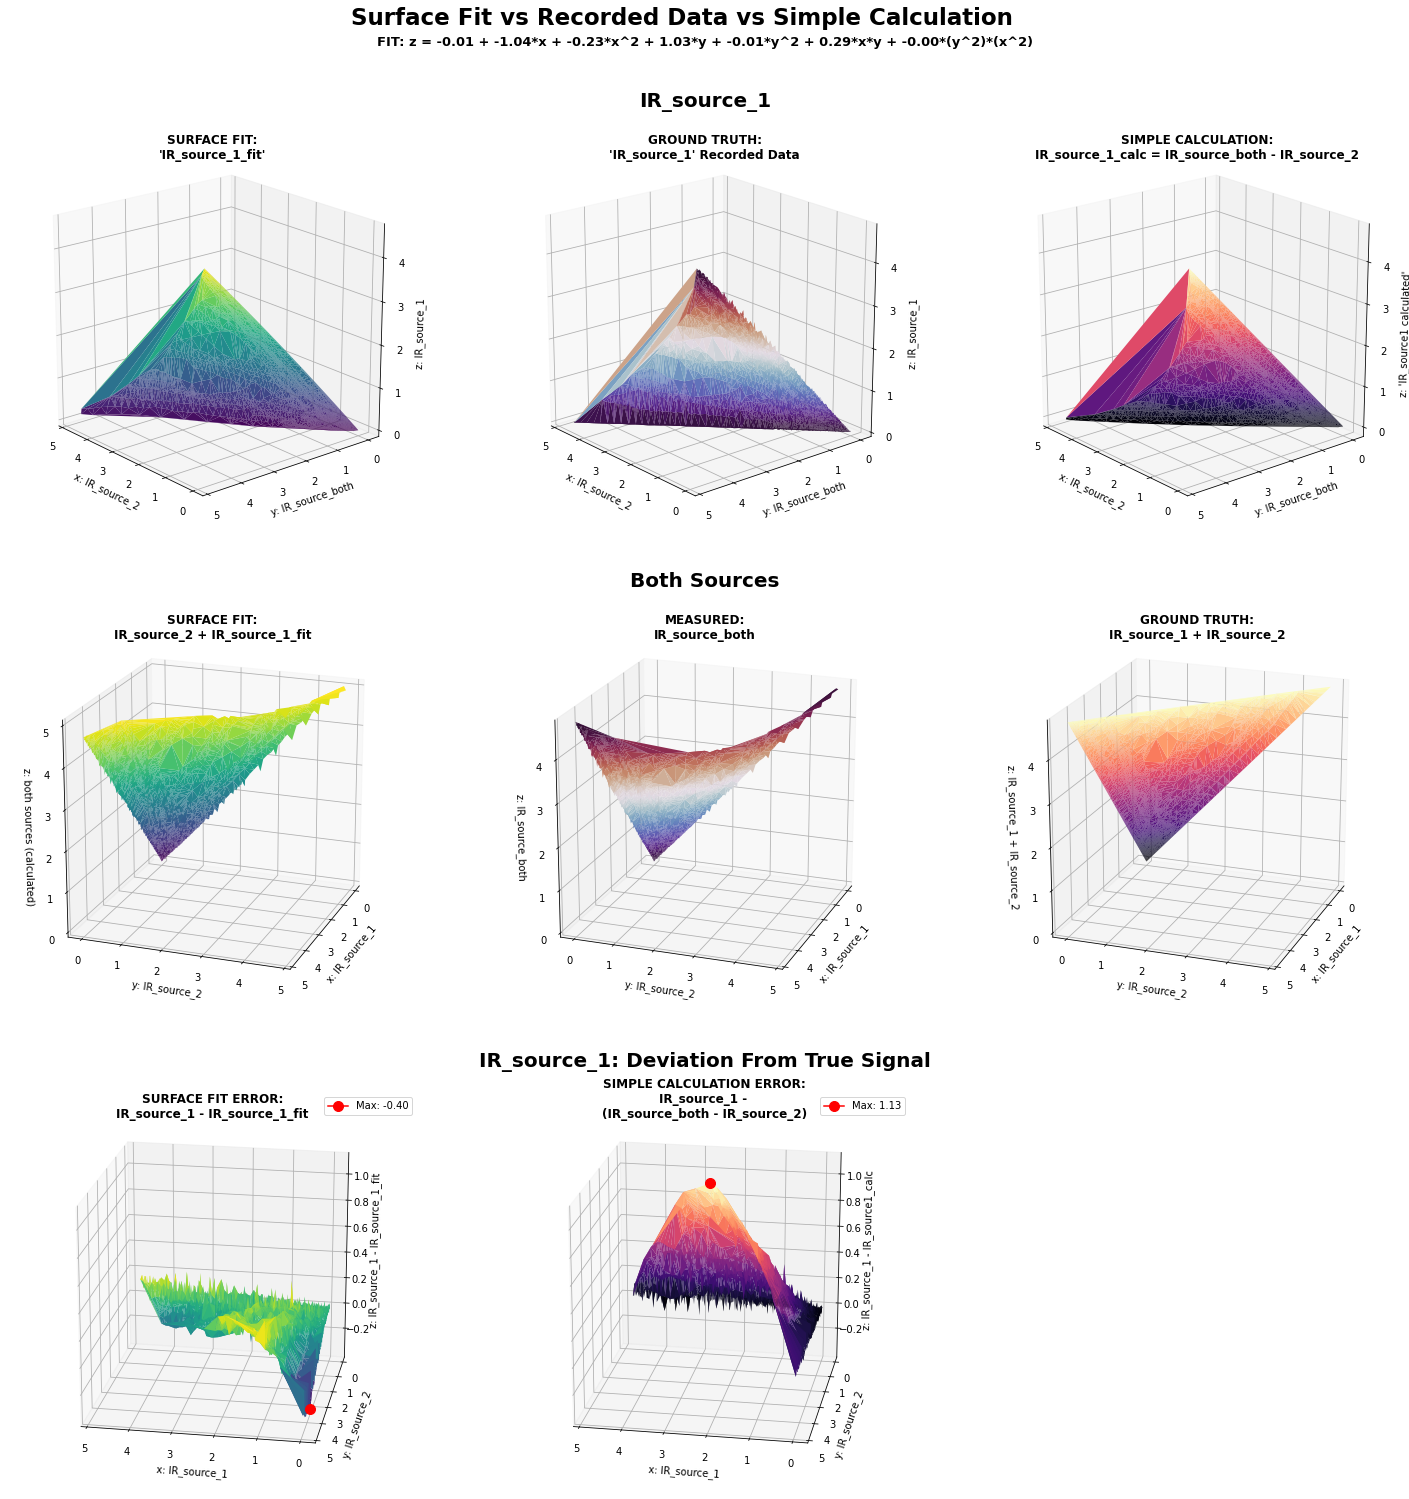

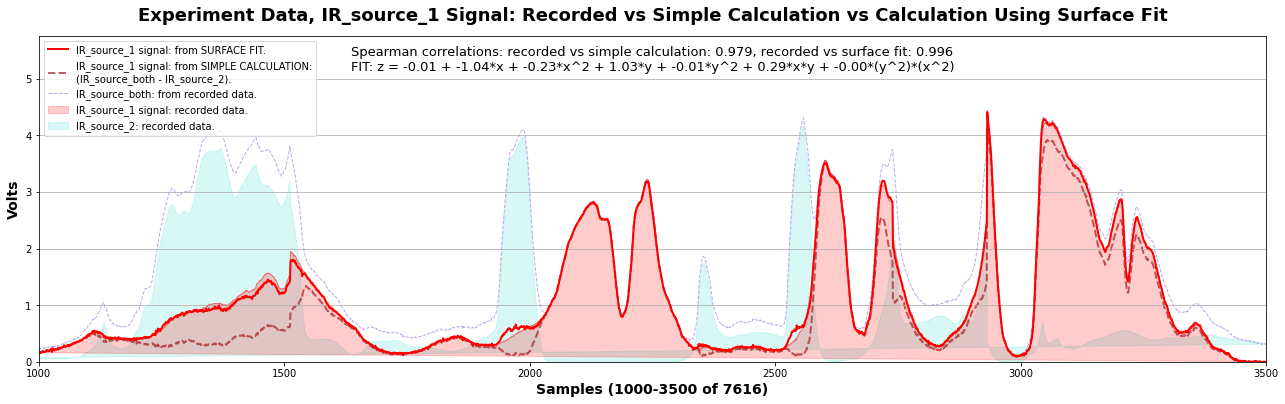


Un-rounded surface fit equation:
z = -0.012438 + -1.036898*x + -0.232035*x^2 + 1.032216*y + -0.011765*y^2 + 0.294534*x*y + -0.001620*(y^2)*(x^2)


In [12]:
############################
# PLOT SURFACE FIT RESULTS #
############################
linePlot_start = 1000
linePlot_range = 2500

# format size of cell output
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

fig = plt.figure(figsize=(25,25))
plt.suptitle("Surface Fit vs Recorded Data vs Simple Calculation", fontsize=23, fontweight='bold', y=0.95, ha='center')
plt.title(surface_fit_string, fontsize=13, fontweight='bold',  y=1.06, ha='center')
plt.axis("off")
row_3 = fig.add_subplot(313)
row_3.set_title("Both Sources: Deviation from Expected", fontsize=20, fontweight='bold', y=1.05)
row_3.axis('off')

## ROW ONE ##
row_1 = fig.add_subplot(311)
row_1.set_title("IR_source_1", fontsize=20, fontweight='bold', y=1.05)
row_1.axis('off')
r1_rotation = 140
# TOP LEFT: IR_source_1 surface fit
ax1 = fig.add_subplot(331, projection='3d')
ax1_z_data = double_IRsource_preProc_df['IR_source1_surfFit']
surface_fit_title = "SURFACE FIT:\n'IR_source_1_fit'"
ax_labels = ["x: %s" % x_data, "y: %s" % y_data, "z: %s" % z_data]
plotSingleSurface(ax1, x, y, ax1_z_data, cm.viridis, surface_fit_title, ax_labels, r1_rotation)
# TOP MIDDLE: recorded data
ax2 = fig.add_subplot(332, projection='3d')
plotSingleSurface(ax2, x, y, z, cm.twilight_shifted, "GROUND TRUTH:\n'IR_source_1' Recorded Data", ax_labels, r1_rotation)
# TOP RIGHT: simple calculation
ax3 = fig.add_subplot(333, projection='3d')
ax3_yData = double_IRsource_preProc_df['IR_source1_calc']
ax3_zData = double_IRsource_preProc_df['IR_source1_calc']
ax_labels = ["x: %s" % x_data, "y: %s" % y_data, "z: 'IR_source1 calculated'"]
plotSingleSurface(ax3, x, y, ax3_zData, cm.magma, "SIMPLE CALCULATION:\nIR_source_1_calc = IR_source_both - IR_source_2", ax_labels, r1_rotation)

## ROW TWO ##
row_2 = fig.add_subplot(312)
row_2.set_title("Both Sources", fontsize=20, fontweight='bold', y=1.05)
row_2.axis('off')
r2_3_x_data = double_IRsource_preProc_df['IR_source_1']
r2_3_y_data = double_IRsource_preProc_df['IR_source_2']
r2_3_rotation = 20
# MID LEFT: both sources surface fit
ax4 = fig.add_subplot(334, projection='3d')
ax4_zData = double_IRsource_preProc_df['surfFit_bothSources']
ax_labels = ['x: IR_source_1', 'y: IR_source_2', "z: both sources (calculated)"]
plotSingleSurface(ax4, r2_3_x_data, r2_3_y_data, ax4_zData, cm.viridis, "SURFACE FIT:\nIR_source_2 + IR_source_1_fit", ax_labels, r2_3_rotation)
# MID MIDDLE: both sources measured
ax5 = fig.add_subplot(335, projection='3d')
ax5_zData = double_IRsource_preProc_df['IR_source_both']
ax_labels = ['x: IR_source_1', 'y: IR_source_2', "z: IR_source_both"]
plotSingleSurface(ax5, r2_3_x_data, r2_3_y_data, ax5_zData, cm.twilight_shifted, "MEASURED:\nIR_source_both", ax_labels, r2_3_rotation)
# MID RIGHT: both sources calculated (see title)
ax6 = fig.add_subplot(336, projection='3d')
ax6_zData = double_IRsource_preProc_df['IR_both_calc']
ax_labels = ['x: IR_source_1', 'y: IR_source_2', "z: IR_source_1 + IR_source_2"]
plotSingleSurface(ax6, r2_3_x_data, r2_3_y_data, ax6_zData, cm.magma, "GROUND TRUTH:\nIR_source_1 + IR_source_2", ax_labels, r2_3_rotation)

## ROW THREE ##
row_3 = fig.add_subplot(313)
row_3.set_title("IR_source_1: Deviation From True Signal", fontsize=20, fontweight='bold', y=1.05)
row_3.axis('off')
r3_rotation = 100
r3_zlim = [min(double_IRsource_preProc_df['surfFit_bothSources_calcMinFit']), max(double_IRsource_preProc_df['IR_source_both_calcMinMeas'])]
# LOW LEFT: both sources, calculated - fit
ax7 = fig.add_subplot(337, projection='3d')
ax7.set_zlim(r3_zlim)
ax7_zData = double_IRsource_preProc_df['surfFit_bothSources_calcMinFit']
ax_labels = ['x: IR_source_1', 'y: IR_source_2', "z: IR_source_1 - IR_source_1_fit"]
plotSingleSurface(ax7, r2_3_x_data, r2_3_y_data, ax7_zData, cm.viridis, "SURFACE FIT ERROR:\nIR_source_1 - IR_source_1_fit", ax_labels, r3_rotation)
max_idx = ax7_zData.abs().idxmax()
max_row = double_IRsource_preProc_df.loc[max_idx]
ax7.plot([max_row['IR_source_1']], [max_row['IR_source_2']], [max_row['surfFit_bothSources_calcMinFit']], marker='o', markersize=10, 
         color='red', zorder=3, label='Max: %.2f' % max_row['surfFit_bothSources_calcMinFit'])
ax7.legend()
# LOW MIDDLE: both sources, calculated - measured
ax8 = fig.add_subplot(338, projection='3d')
ax8.set_zlim(r3_zlim)
ax8_zData = double_IRsource_preProc_df['IR_source_both_calcMinMeas']
ax_labels = ['x: IR_source_1', 'y: IR_source_2', "z: IR_source_1 - IR_source1_calc"]
plotSingleSurface(ax8, r2_3_x_data, r2_3_y_data, ax8_zData, cm.magma, "SIMPLE CALCULATION ERROR:\nIR_source_1 - \n(IR_source_both - IR_source_2)", ax_labels, r3_rotation)
max_idx = ax8_zData.abs().idxmax()
max_row = double_IRsource_preProc_df.loc[max_idx]
ax8.plot([max_row['IR_source_1']], [max_row['IR_source_2']], [max_row['IR_source_both_calcMinMeas']], marker='o', markersize=10, 
         color='red', zorder=3, label='Max: %.2f' % max_row['IR_source_both_calcMinMeas'])
ax8.legend()
plt.show()

# FIGURE 2: LINE PLOTS
line_1 = double_IRsource_preProc_df['IR_source_1'][linePlot_start:linePlot_start+linePlot_range].tolist()
line_2 = double_IRsource_preProc_df['IR_source1_surfFit'][linePlot_start:linePlot_start+linePlot_range].tolist()
line_3 = double_IRsource_preProc_df['IR_source1_calc'][linePlot_start:linePlot_start+linePlot_range].tolist()
line_4 = double_IRsource_preProc_df['IR_source_2'][linePlot_start:linePlot_start+linePlot_range].tolist()
line_5 = double_IRsource_preProc_df['IR_source_both'][linePlot_start:linePlot_start+linePlot_range].tolist()
line_x = [x + linePlot_start for x in range(linePlot_range)]
fig = plt.figure(figsize=(22,6))
ax1 = fig.add_subplot(111)
#ax1.set_facecolor('floralwhite')
ax1.set_title("Experiment Data, IR_source_1 Signal: Recorded vs Simple Calculation vs Calculation Using Surface Fit", fontsize=18, fontweight='bold', pad=15)
ax1.set_xlim([linePlot_start,linePlot_start+linePlot_range])
ax1.set_ylim([0,1.2*saturation_voltage])
ax1.set_ylabel('Volts', fontsize=14, fontweight='bold')
ax1.set_xlabel('Samples (%d-%d of %d)' %(linePlot_start, linePlot_start+linePlot_range, len(z)), fontsize=14, fontweight='bold')
ax1.plot(line_x, line_1, alpha=0.4, color='red', linewidth=1)
ax1.fill(line_x, line_1, alpha=0.2, label='IR_source_1 signal: recorded data.', color='red')
ax1.plot(line_x, line_2, label='IR_source_1 signal: from SURFACE FIT.',color='red', linewidth=2)
ax1.plot(line_x, line_3, alpha=0.6, linestyle='--',
         label='IR_source_1 signal: from SIMPLE CALCULATION:\n(IR_source_both - IR_source_2).', color='maroon', zorder=0, linewidth=2)
ax1.fill(line_x, line_4, alpha=0.2, label='IR_source_2: recorded data.', color='turquoise', zorder=-1)
ax1.plot(line_x, line_5, alpha=0.6, linestyle='--', label='IR_source_both: from recorded data.', color='mediumpurple', zorder=0, linewidth=1)
ax1.legend(loc='upper left')
corr_string = 'Spearman correlations: recorded vs simple calculation: %0.3f, recorded vs surface fit: %.3f\n%s' % \
        (source1Corr_rec_calc, source1Corr_rec_surf, surface_fit_string)
ax1.text(ax1.get_xlim()[0]+(ax1.get_xlim()[1]-ax1.get_xlim()[0])/2, ax1.get_ylim()[1]*0.97, corr_string, ha='center', va='top', fontsize=13)
plt.grid(axis = 'y')
plt.show()

# print unrounded surface fit coefficients
surface_fit_string_unrounded = "z = %f + %f*x + %f*x^2 + %f*y + %f*y^2 + %f*x*y + %f*(y^2)*(x^2)" % \
                                                             (fit[0],fit[1],fit[2],fit[3],fit[4], fit[5], fit[6])
print("\nUn-rounded surface fit equation:\n%s" % surface_fit_string_unrounded)

As can be seen in the final plot above, the `IR_source_1` signal calculated using the surface fit (thick red line) shows a marked improvement over the **simple calculation** (broken maroon line), when compared to the true `IR_source_1` signal (filled red area).

The surface-fit 2D polynomial also showed significant real-time improvement over the **simple calculation** in dealing with changing background light and LED signal levels, when used in the 'Process' stage to calculate `LEDsignal` samples, as described in **Fig 1, Section 1**. This was implemented using the following Arduino code:

In [13]:
 ///////////////////////////
// USER-DEFINABLE VALUES //
///////////////////////////
#define PULSE_VCC               7 // digital pin, pulse IR LED
#define READ_PIN                A1 // analog pin, read phototransistor
#define IR_TEST_LED_VCC         8 // digital pin, power IR LED for background light simulation
#define ADC_PRESCALER_VAL       128 // sets the value of the ADC prescaler
#define BAUD_RATE               9600
#define SAMPLE_DELAY            500 // us delay between samples. There is a min sample time of ~16us. 380 works well.
#define PRINT_BG_MAX            false
#define PRINT_UNFILTERED        false
bool PRINT_BG_LIGHT =           true; // print running background light max value
bool PROC_SIGNAL_FIT =          false; // turn 2D polynomial processing on if true, use simple subtraction if false
////////////////////////////////
// END USER-DEFINABLE VALUESS //
////////////////////////////////

float bg_light = 0;
float bg_max = 0;
float pulse_sampled = 0;
float pulse_sampled_adjusted = 0;
float output = 0;
String user_input;
float signal_out = 0;

// valid arg values are 2, 4, 8, 16, 32, 64, 128
void set_ADC_prescaler(int val) {
  if (val == 2) {
    bitSet(ADCSRA,ADPS0);
    bitClear(ADCSRA,ADPS1);
    bitClear(ADCSRA,ADPS2);
  } else if (val == 4) {
    bitClear(ADCSRA,ADPS0);
    bitSet(ADCSRA,ADPS1);
    bitClear(ADCSRA,ADPS2);
  } else if (val == 8) {
    bitSet(ADCSRA,ADPS0);
    bitSet(ADCSRA,ADPS1);
    bitClear(ADCSRA,ADPS2);
  } else if (val == 16) {
    bitClear(ADCSRA,ADPS0);
    bitClear(ADCSRA,ADPS1);
    bitSet(ADCSRA,ADPS2);
  } else if (val == 32) {
    bitSet(ADCSRA,ADPS0);
    bitClear(ADCSRA,ADPS1);
    bitSet(ADCSRA,ADPS2);
  } else if (val == 64) {
    bitClear(ADCSRA,ADPS0);
    bitSet(ADCSRA,ADPS1);
    bitSet(ADCSRA,ADPS2);
  } else if (val == 128) {
    bitSet(ADCSRA,ADPS0);
    bitSet(ADCSRA,ADPS1);
    bitSet(ADCSRA,ADPS2);
  } else {
    return;
  }
}

// 2D polynomial developed through data analysis/surface fit
float process_data(float bg_light, float pulse_sampled) {
  return -0.024551 + -0.986701*bg_light + -0.257718*sq(bg_light) + 1.038322*pulse_sampled + -0.012698*sq(pulse_sampled) + 
                                                    0.283598*bg_light*pulse_sampled + -0.001620*sq(pulse_sampled)*sq(bg_light);
}

void setup() {
  Serial.begin(BAUD_RATE);
  pinMode(PULSE_VCC, OUTPUT);
  pinMode(IR_TEST_LED_VCC, OUTPUT);
  digitalWrite(IR_TEST_LED_VCC, HIGH); // turn on test IR LED
  digitalWrite(PULSE_VCC, LOW); // turn off IR LED for 1 second
  delay(1000);
}

void loop() {
  // check for/process user input
  while (Serial.available()) {
      user_input = Serial.readString();
      if (user_input == "bg_on") {
        PRINT_BG_LIGHT = true;
      }
      else if (user_input == "bg_off") {
        PRINT_BG_LIGHT = false;
      }
      if (user_input == "fit_on") {
        PROC_SIGNAL_FIT = true;
      }
      if (user_input == "fit_off") {
        PROC_SIGNAL_FIT = false;
      }
  
  }
  // acquire data
  bg_light = analogRead(READ_PIN);
  digitalWrite(PULSE_VCC, HIGH);
  delayMicroseconds(SAMPLE_DELAY);
  pulse_sampled = analogRead(READ_PIN);
  digitalWrite(PULSE_VCC, LOW);
  delayMicroseconds(SAMPLE_DELAY);

  // get max bg light values
  if (bg_light > bg_max) {
    bg_max = bg_light;
  }
  // convert to voltages
  bg_light = bg_light*5/1023;
  pulse_sampled = pulse_sampled*5/1023;
  
  // adjust with fit
  if (PROC_SIGNAL_FIT) {
    signal_out = process_data(bg_light, pulse_sampled);
  }
  else {
    signal_out = pulse_sampled - bg_light;
  }
  
  // OUTPUT
  if (PRINT_BG_LIGHT) {
    Serial.print(bg_light);
    Serial.print(" ");
    if (PRINT_BG_MAX) {
      Serial.print(bg_max);
      Serial.print(" ");
    }
  }
  Serial.print(signal_out);
  if (PRINT_UNFILTERED) {
    Serial.print(" ");
    Serial.print(pulse_sampled);
    Serial.print(" ");
  }
  Serial.print("\n");
}

SyntaxError: ignored

## 6. Conclusion

While this particular polynomial will obviously not transfer to all infrared phototransistors, it is hoped that this process provides a simple way to develop a background light filtering algorithm for a range of IR sensors and applications (provided the IR source can be controlled/pulsed). The relative ease with which data was gathered, how little data cleaning was required and the robustness of the result gives some confidence that this is possible, further expanding the usefulness and reliability of infrared sensors, and may even extend more broadly to other sensors that have trouble filtering backgound noise.

In [ ]:
#@title (obselete code)
'''
# Used in both sides: center-line of LHS surface datapoints
line_vals = double_IRsource_preProc_df.query('abs(IR_source_1 - IR_source_2) < 0.05')

# LHS: ZOOMED PLOT
# surface parameters
x_vals = double_IRsource_preProc_df['IR_source_1']
y_vals = double_IRsource_preProc_df['IR_source_2']
z_vals = double_IRsource_preProc_df['IR_source_both']
title = "Dissecting the IR_source_both Surface: 1) The 'Spine'"
ax_labels = ['IR_source_1', 'IR_source_2', 'IR_source_both']
colormap = cm.twilight_shifted
zoom_plot = True
zoom_rotation = 20
frame_lw = 1
#plot
fig = plt.figure(figsize=(16,8))
plt.suptitle(title, fontsize=20, fontweight="bold", y=1)
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_xlabel("x: " + ax_labels[0]  + " (V)", fontsize=13)
ax1.set_ylabel("y: " + ax_labels[1]  + " (V)", fontsize=13)
ax1.set_zlabel("z: " + ax_labels[2] + " (V)", fontsize=13)
#ax1.set_title("(%d° rotation)" % (zoom_rotation), fontsize=15)
ax1.plot_trisurf(x_vals, y_vals, z_vals, cmap=colormap, edgecolor='none', alpha=0.5, zorder=-1, antialiased=False)
# add cross-section line
ax1.plot(line_vals['IR_source_1'], line_vals['IR_source_2'], line_vals['IR_source_both'], linewidth=7, color='limegreen', zorder=2)
# add RHS frame
ax1.plot([0,0], [0,0], [0, saturation_voltage], linewidth=frame_lw, linestyle='--', color='black', zorder=2)
ax1.plot([0,saturation_voltage], [0,saturation_voltage], [saturation_voltage]*2, linewidth=frame_lw, linestyle='--', color='black', zorder=2)
ax1.plot([saturation_voltage]*2, [saturation_voltage]*2, [saturation_voltage,0], linewidth=frame_lw, linestyle='--', color='black', zorder=2)
ax1.plot([0, saturation_voltage], [0, saturation_voltage], [0]*2, linewidth=frame_lw, linestyle='--', color='black', zorder=2)
ax1.view_init(20, zoom_rotation)
# add expected on RHS
ax1.plot([0, saturation_voltage/2], [0, saturation_voltage/2], [0, saturation_voltage], linewidth=frame_lw, linestyle='--', alpha=0.5, color='gray', zorder=2)

# RHS: CROSS-SECTION PLOT
ax2 = fig.add_subplot(122)
ax2.set_title("Cross-Section of Surface Spine: IR_source_1 = IR_source_2", fontsize=12, fontweight='bold')
ax2.set_xlabel("IR_source_1 and IR_source_2 (V)", fontsize=13)
ax2.set_ylabel("IR_source_both", fontsize=13, rotation='horizontal', ha='right')
ax2.set_xlim([0, saturation_voltage])
ax2.set_ylim([0, saturation_voltage])
ax2.scatter(line_vals['IR_source_1'], line_vals['IR_source_both'], linewidth=1, color='limegreen', zorder=2)
fig.tight_layout(pad=8)
# add trendline
trendline = np.polyfit(line_vals['IR_source_1'], line_vals['IR_source_both'], 1)
p = np.poly1d(trendline)
ax2.plot(line_vals['IR_source_1'], p(line_vals['IR_source_1']), color='lightcoral', linewidth=3, zorder=-1)
ax2.text(ax2.get_xlim()[1]/1.9, max(p(line_vals['IR_source_1'])), 'Trendline:\ny = %.2fx + %.2f' % tuple(trendline), ha='left', va='center', fontsize=13)
ax2.plot([0, saturation_voltage/2], [0, saturation_voltage], color='darkgray', linestyle='--', linewidth=2, zorder=-1)
ax2.text(ax2.get_xlim()[1]/2.8, saturation_voltage*0.95, 'Expected:\ny = 2x', ha='center', va='top', color='grey', fontsize=13)
plt.show()
'''

In [ ]:
#@title (obselete code)
'''
# Used in both sides: cross-section of LHS surface datapoints, and their
# x values for the RHS plot
precision_threshold = 0.05
sortBy = 'IR_source_1'
line_vals1 = double_IRsource_preProc_df.query('abs(IR_source_1 + IR_source_2 - %f) < %f' % (saturation_voltage, precision_threshold)).sort_values(sortBy)
line_vals1_x = [x - line_vals1['IR_source_1'].max()/2 for x in line_vals1['IR_source_1']]
line_vals2 = double_IRsource_preProc_df.query('abs(IR_source_1 + IR_source_2 - %f) < %f' % (saturation_voltage-1, precision_threshold)).sort_values(sortBy)
line_vals2_x = [x - line_vals2['IR_source_1'].max()/2 for x in line_vals2['IR_source_1']]
line_vals3 = double_IRsource_preProc_df.query('abs(IR_source_1 + IR_source_2 - %f)  < %f' % (saturation_voltage-2, precision_threshold)).sort_values(sortBy)
line_vals3_x = [x - line_vals3['IR_source_1'].max()/2 for x in line_vals3['IR_source_1']]
line_vals4 = double_IRsource_preProc_df.query('abs(IR_source_1 + IR_source_2 - %f)  < %f' % (saturation_voltage-3, precision_threshold)).sort_values(sortBy)
line_vals4_x = [x - line_vals4['IR_source_1'].max()/2 for x in line_vals4['IR_source_1']]
line_vals5 = double_IRsource_preProc_df.query('abs(IR_source_1 + IR_source_2 - %f)  < %f' % (saturation_voltage-4, precision_threshold)).sort_values(sortBy)
line_vals5_x = [x - line_vals5['IR_source_1'].max()/2 for x in line_vals5['IR_source_1']]


# LHS: ZOOMED PLOT
# surface parameters
x_vals = double_IRsource_preProc_df['IR_source_1']
y_vals = double_IRsource_preProc_df['IR_source_2']
z_vals1 = double_IRsource_preProc_df['IR_source_both']
z_vals2 = double_IRsource_preProc_df['IR_both_calc']
zoom_rotation = 110
title = "Dissecting the IR_source_both Surface: 2) The 'Ribs'"
ax_labels = ['IR_source_1', 'IR_source_2', 'IR_source_both']
colormap = cm.twilight_shifted
zoom_rotation = 100
frame_lw = 1
#plot LHS
fig = plt.figure(figsize=(16,8))
plt.suptitle(title, fontsize=20, fontweight="bold", y=1)
ax1 = fig.add_subplot(121, projection='3d')
ax1.set_xlabel("x: " + ax_labels[0]  + " (V)", fontsize=13)
ax1.set_ylabel("y: " + ax_labels[1]  + " (V)", fontsize=13)
ax1.set_zlabel("z: " + ax_labels[2] + " (V)", fontsize=13)
ax1.plot_trisurf(x_vals, y_vals, z_vals1, cmap=colormap, edgecolor='none', alpha=0.4, zorder=3, antialiased=False)
ax1.plot_trisurf(x_vals, y_vals, z_vals2, color='lightcoral', edgecolor='none', alpha=0.02, zorder=1, antialiased=False)
# add cross-section lines to LHS
ax1.plot(line_vals1['IR_source_1'], line_vals1['IR_source_2'], line_vals1['IR_source_both'], linewidth=7, color='limegreen', zorder=2)
ax1.plot(line_vals2['IR_source_1'], line_vals2['IR_source_2'], line_vals2['IR_source_both'], linewidth=7, color='limegreen', zorder=2)
ax1.plot(line_vals3['IR_source_1'], line_vals3['IR_source_2'], line_vals3['IR_source_both'], linewidth=7, color='limegreen', zorder=2)
ax1.plot(line_vals4['IR_source_1'], line_vals4['IR_source_2'], line_vals4['IR_source_both'], linewidth=7, color='limegreen', zorder=2)
ax1.plot(line_vals5['IR_source_1'], line_vals5['IR_source_2'], line_vals5['IR_source_both'], linewidth=7, color='limegreen', zorder=2)
# add RHS frame border to LHS plot
ax1.plot([saturation_voltage]*2, [0]*2, [0, saturation_voltage], linewidth=frame_lw, linestyle='--', color='black', zorder=2)
ax1.plot([saturation_voltage,0], [0,saturation_voltage], [saturation_voltage]*2, linewidth=frame_lw, linestyle='--', color='black', zorder=2)
ax1.plot([0]*2, [saturation_voltage]*2, [saturation_voltage,0], linewidth=frame_lw, linestyle='--', color='black', zorder=2)
ax1.plot([0, saturation_voltage], [saturation_voltage,0], [0]*2, linewidth=frame_lw, linestyle='--', color='black', zorder=2)
# add center-lines to LHS
ax1.plot([saturation_voltage/2]*2, [saturation_voltage/2]*2, [0, saturation_voltage], linewidth=frame_lw, linestyle='--', color='gray', alpha=0.7, zorder=4)
ax1.plot([0, saturation_voltage], [0, saturation_voltage], [0]*2, linewidth=frame_lw, linestyle='--', color='gray', alpha=0.7, zorder=4)
ax1.view_init(20, zoom_rotation)

# RHS: CROSS-SECTION PLOT
ax2 = fig.add_subplot(122)
ax2.set_title("Surface Cross-Sections at x + y = C Volts +/-%.2f"% (precision_threshold), fontsize=13, fontweight='bold')
ax2.set_xlabel("Distance from centre-plane x = y", fontsize=13, ha='center')
ax2.set_ylabel("IR_source_both", fontsize=13, rotation='horizontal', ha='right')
ax2.set_xlim([-saturation_voltage/2, saturation_voltage/2])
ax2.set_ylim([0, saturation_voltage*1.1])
# scatter points RHS
ax2.scatter(line_vals1_x, line_vals1['IR_source_both'], linewidth=1, color='limegreen', zorder=2, label='Surface points for each C')
ax2.scatter(line_vals2_x, line_vals2['IR_source_both'], linewidth=1, color='limegreen', zorder=2)
ax2.scatter(line_vals3_x, line_vals3['IR_source_both'], linewidth=1, color='limegreen', zorder=2)
ax2.scatter(line_vals4_x, line_vals4['IR_source_both'], linewidth=1, color='limegreen', zorder=2)
ax2.scatter(line_vals5_x, line_vals5['IR_source_both'], linewidth=1, color='limegreen', zorder=2)
# add redlines RHS
ax2.plot([min(line_vals1_x), max(line_vals1_x)], [saturation_voltage]*2, linestyle='--', color='lightcoral', zorder=-2, label='C values (ie expected cross-sections)')
ax2.plot([min(line_vals2_x), max(line_vals2_x)], [saturation_voltage-1]*2, linestyle='--', color='lightcoral', zorder=-2)
ax2.plot([min(line_vals3_x), max(line_vals3_x)], [saturation_voltage-2]*2, linestyle='--', color='lightcoral', zorder=-2)
ax2.plot([min(line_vals4_x), max(line_vals4_x)], [saturation_voltage-3]*2, linestyle='--', color='lightcoral', zorder=-2)
ax2.plot([min(line_vals5_x), max(line_vals5_x)], [saturation_voltage-4]*2, linestyle='--', color='lightcoral', zorder=-2)
ax2.plot([0,0], [0, ax2.get_ylim()[1]], linestyle='-', color='gray', alpha=0.3, zorder=-2)
fig.tight_layout(pad=8)
ax2.legend()
plt.show()
'''